# Compare Models

This notebook compares various GFW models based on the `measure_speed` and `measure_course` with each other
and with the models from Dalhousie University.  Note that the distance-to-shore cutoff was disabled in the
Dalhousie models, so none of the models compared here are using distance-to-shore as a feature.

In [1]:
from __future__ import print_function, division
%matplotlib inline
import os.path
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from vessel_scoring.utils import clone_subset
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics
import pandas as pd
import warnings; warnings.filterwarnings('ignore')

In [2]:
data = vessel_scoring.models.load_data('../datasets')


GEARS = {'ps': 'Purse seiners', 'trawl': 'Trawlers', 'longliner': 'Long liners'}


xtrainmap = {
    gear: vessel_scoring.utils.concatenate_different_recarrays([
            data[i[0]][i[1]]
            for i in ([('kristina_' + gear, 'train'), ('kristina_' + gear, 'cross')]
                      + [('slow-transits', 'train'), ('slow-transits', 'cross')] * vessel_scoring.models.TRANSIT_WEIGHT)
        ])
    for gear in GEARS.keys()
}
          

xtestmap = {
    gear: data["kristina_" + gear]['test']
    for gear in GEARS.keys()
}

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.83|0.24|0.38|
|Logistic (MW & daylight)|0.79|0.22|0.35|
|Logistic (MW)|0.45|0.16|0.24|
|Logistic (SW)|0.21|0.04|0.07|
|Random Forest|0.42|0.08|0.14|
|Random Forest (MW & daylight & speed)|0.81|0.31|0.45|
|Random Forest (MW & daylight)|0.89|0.28|0.43|

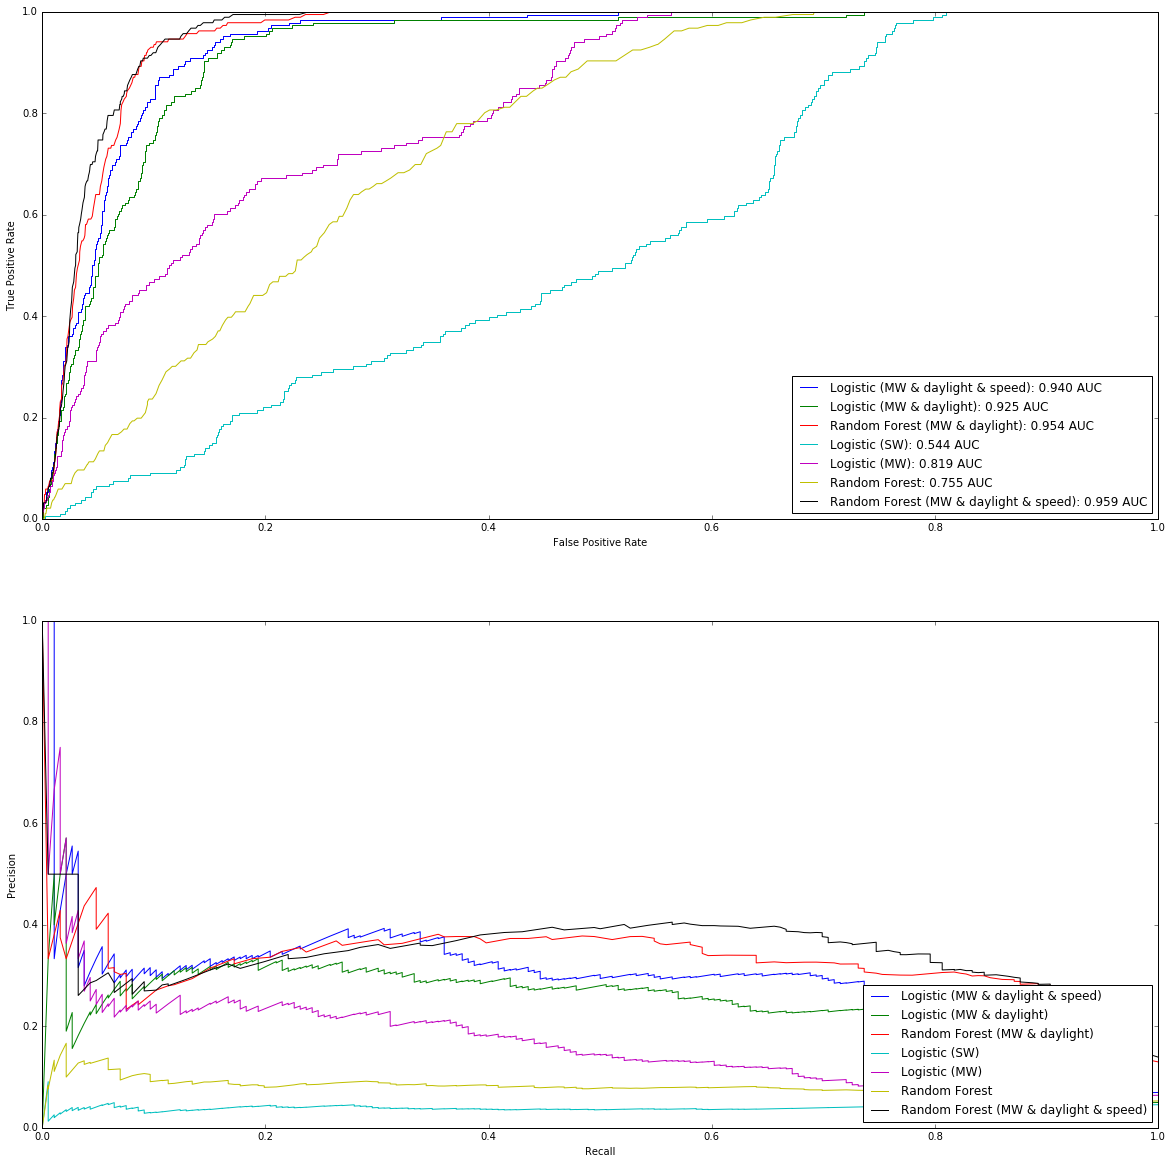

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.87|0.94|0.91|
|Logistic (MW & daylight)|0.87|0.94|0.91|
|Logistic (MW)|0.87|0.94|0.91|
|Logistic (SW)|0.76|0.90|0.82|
|Random Forest|0.88|0.90|0.89|
|Random Forest (MW & daylight & speed)|0.92|0.93|0.93|
|Random Forest (MW & daylight)|0.92|0.93|0.93|

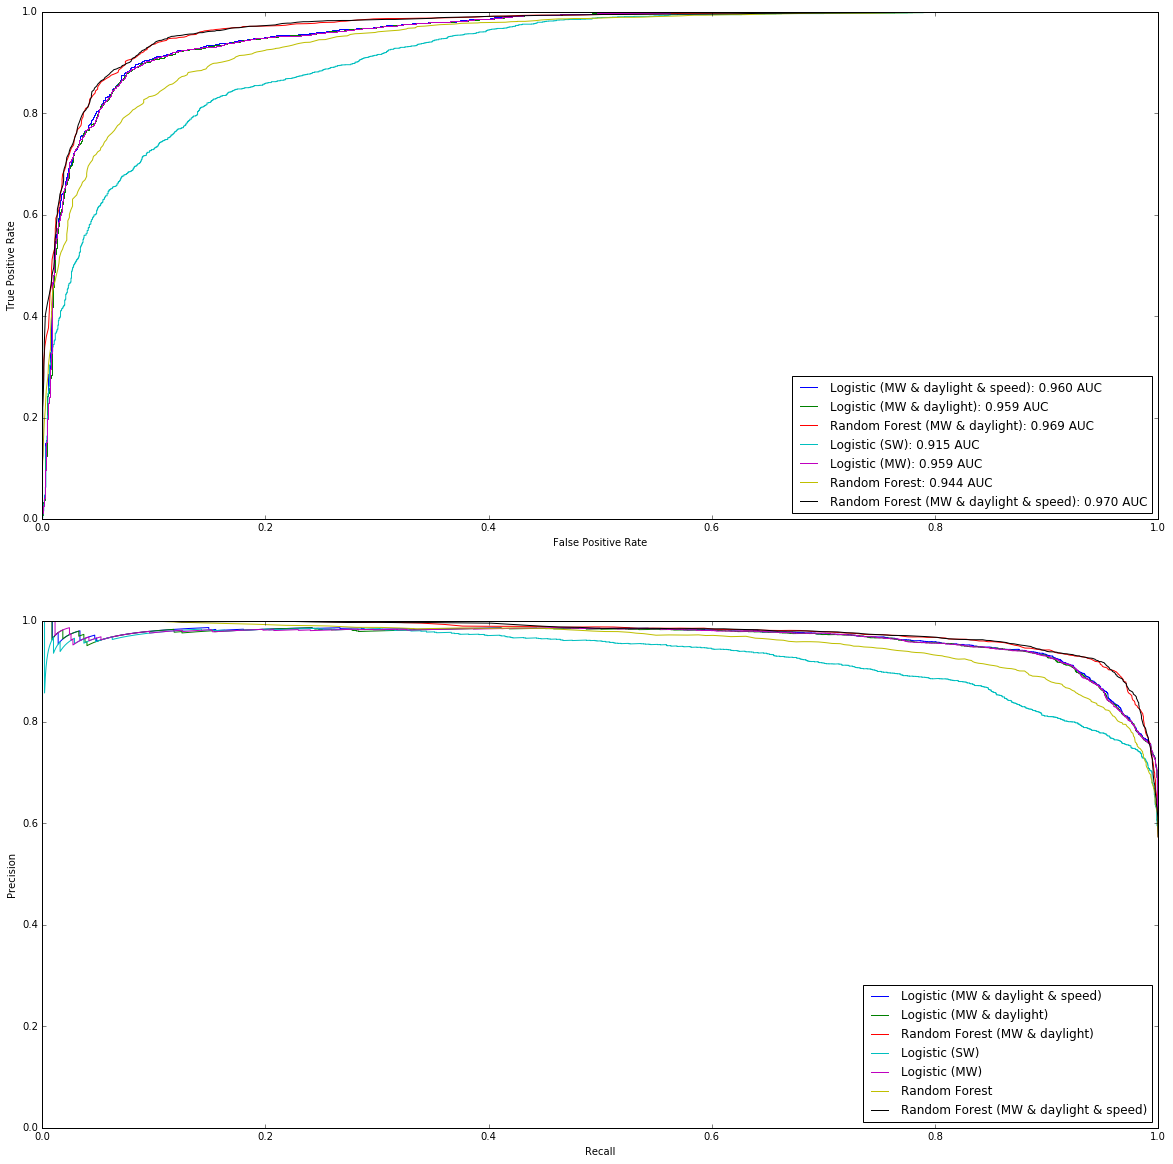

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.91|0.96|0.93|
|Logistic (MW & daylight)|0.91|0.96|0.93|
|Logistic (MW)|0.91|0.96|0.93|
|Logistic (SW)|0.81|0.94|0.87|
|Random Forest|0.87|0.95|0.91|
|Random Forest (MW & daylight & speed)|0.91|0.97|0.94|
|Random Forest (MW & daylight)|0.90|0.97|0.93|

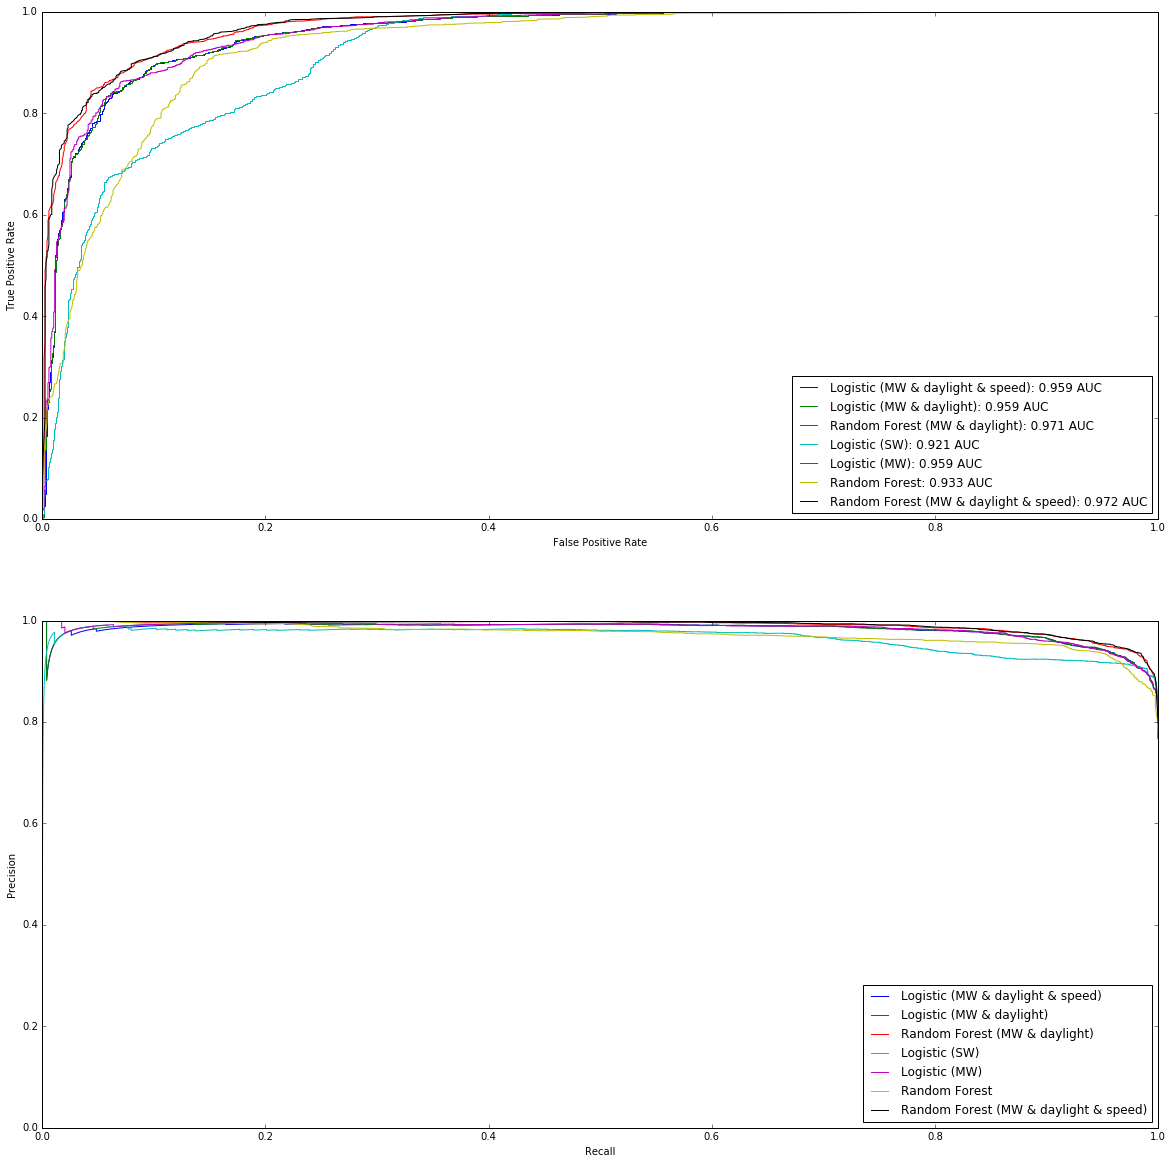

In [6]:

for gear, title in GEARS.iteritems():
    xtest = xtestmap[gear]
    xtrain = xtrainmap[gear]
    test_mmsi = set(xtest['mmsi'])
    
    trained_models = [(name, train_model_on_data(spec['model'], xtrain))
                      for (name, spec) in vessel_scoring.models.untrained_models.iteritems()
                      if spec.get("compare_models", False)]

    predictions = {}

    dal_name = "../dal_{}_results.csv".format(gear)
    if os.path.exists(dal_name):
        dal_res = pd.read_csv(dal_name)
        mask = np.array([(x in test_mmsi) for x in dal_res['mmsi']]).astype(bool)
        predictions['dal'] = (dal_res.preds[mask], dal_res.classification[mask])
        # Fix predictions for Trawler.py
        predictions['dal'] = ([{'F': 1, 'N': 0}.get(x, x) for x in predictions['dal'][0]], predictions['dal'][1])

    for name, mdl in trained_models:
        predictions[name] = ((mdl.predict_proba(xtest)[:,1] > 0.5), xtest['classification'])


    display(HTML("<h2>{}</h2>".format(title)))

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name in sorted(predictions):
        pred, actual = predictions[name]
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, xtest)
    
    display(HTML("<hr/>"))

## Preparing Dalhouise Data 


In the `vessel-scoring` repo:

```
python scripts/make_ps_data_ready_for_dal.py
```

I disabled distshore in dal for the models that still have it using some hackery so that (a) it ran faster and (b) the comparisons were 'fair'.

Then in the `dal` repo:

```

# First, turned off distshore in the models that still have it using some hackery.

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_purse_seine.measures.from_npz.csv  ../vessel-scoring/dal_purse_seine_results.csv dalhouse/models/timeofday/

dal timothyhochberg$ Rscript dalhouse/models/trawler.R ../vessel-scoring/datasets/kristina_trawler.measures.from_npz.csv  ../vessel-scoring/dal_trawler_results.csv dalhouse/models/coastline/ data/training/trawl.csv 

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_longliner.measures.from_npz.csv  ../vessel-scoring/dal_longliner_results.csv dalhouse/models/timeofday/


```

In [ ]:
|